In [18]:
import pandas as pd
import glob
import random

In [19]:
SEED = 42
random.seed(SEED)

df = pd.read_csv("resources/data/gpqa_diamond.csv")

answer_columns = [
    "Correct Answer",
    "Incorrect Answer 1",
    "Incorrect Answer 2",
    "Incorrect Answer 3"
]

options_labels = ["A", "B", "C", "D"]

formatted_questions = []
labels = []

for _, row in df.iterrows():

    shuffled_columns = random.sample(answer_columns, len(answer_columns))
    shuffled_options = {opt: row[col] for opt, col in zip(options_labels, shuffled_columns)}

    for opt in options_labels:
        question_text = f"Question: {row['Question']}\\n"
        choice_text = f"Is the following answer correct?\\n Answer: {shuffled_options[opt]}"
        instruction_text = "\\nOnly output 'Yes' or 'No'."
        prompt_text = f"{question_text}{choice_text}{instruction_text}"

        is_correct = "Yes" if shuffled_columns[options_labels.index(opt)] == "Correct Answer" else "No"

        formatted_questions.append(prompt_text)
        labels.append(is_correct)

gpqa_df = pd.DataFrame({
    "input": formatted_questions,
    "target": labels
})

In [20]:
def get_model_problem_summary(globpath, n=256):
    df = pd.concat([pd.read_csv(filepath, index_col=0).head(n).assign(id=int(filepath.split("/")[-1].split('.')[0])) for filepath in sorted(glob.glob(globpath))]).reset_index(drop=True)
    df2 = gpqa_df.target.to_frame()
    df2['answer'] = df.groupby('id').answer.agg(lambda x: x.value_counts().index[0])
    df2['trials'] = df.groupby('id').token_usage.count()
    df2['token_usage'] = df.groupby('id').token_usage.sum()
    return df2

def get_model_summary(df):
    return pd.Series({
        "mean_token_usage": df.token_usage.mean(),
        "estimated_price": df.token_usage.sum() * 4.40 / 1e6,
        "accuracy": (df.target == df.answer).mean(),
    })

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

Text(0.5, 1.0, 'Token Usage')

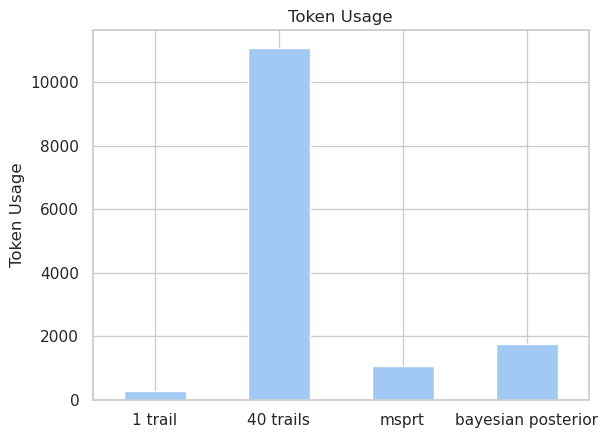

In [22]:
ax = (pd.Series([
    get_model_summary(get_model_problem_summary("published/gpqa_bayesian_posterior_yesno/*")).mean_token_usage,
    get_model_summary(get_model_problem_summary("published/gpqa_msprt_yesno/*")).mean_token_usage,
    get_model_summary(get_model_problem_summary("published/gpqa_40_trail_yesno/*")).mean_token_usage,
    get_model_summary(get_model_problem_summary("published/gpqa_1_trail_yesno/*")).mean_token_usage,
])[::-1]).to_frame().assign(label=["1 trail", "40 trails","msprt","bayesian posterior"]).set_index('label').plot.bar(ylabel="Token Usage", xlabel="", rot=0, legend=False)

plt.title("Token Usage")

Text(0.5, 1.0, 'Accuracy')

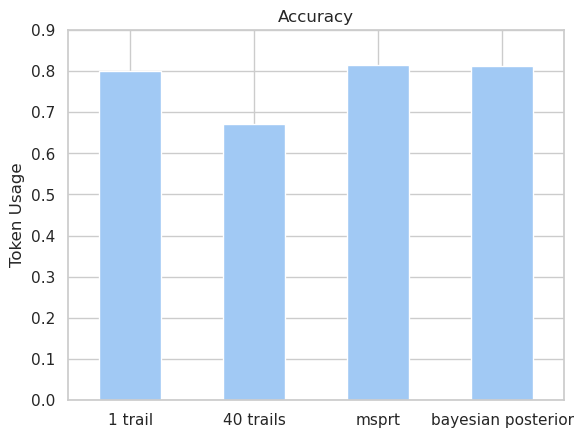

In [23]:
ax = (pd.Series([
    get_model_summary(get_model_problem_summary("published/gpqa_bayesian_posterior_yesno/*")).accuracy,
    get_model_summary(get_model_problem_summary("published/gpqa_msprt_yesno/*")).accuracy,
    get_model_summary(get_model_problem_summary("published/gpqa_40_trail_yesno/*")).accuracy,
    get_model_summary(get_model_problem_summary("published/gpqa_1_trail_yesno/*")).accuracy,
])[::-1]).to_frame().assign(label=["1 trail","40 trails", "msprt","bayesian posterior"]).set_index('label').plot.bar(ylabel="Token Usage", xlabel="", rot=0, legend=False)


plt.ylim(0, 0.9)
plt.title("Accuracy")

In [25]:
SEED = 42
random.seed(SEED)

df = pd.read_csv("resources/data/gpqa_diamond.csv")

answer_columns = [
    "Correct Answer",
    "Incorrect Answer 1",
    "Incorrect Answer 2",
    "Incorrect Answer 3"
]

options_labels = ["A", "B", "C", "D"]

formatted_questions = []
correct_answers = []

for _, row in df.iterrows():

    shuffled_columns = random.sample(answer_columns, len(answer_columns))

    shuffled_options = {opt: row[col] for opt, col in zip(options_labels, shuffled_columns)}

    question_text = f"Question: {row['Question']}\\n"
    choices_text = "\\n".join([f"{opt}. {shuffled_options[opt]}" for opt in options_labels])
    prompt_text = f"{question_text}{choices_text}"

    correct_option = [opt for opt, col in zip(options_labels, shuffled_columns) if col == "Correct Answer"][0]

    formatted_questions.append(prompt_text)
    correct_answers.append(correct_option)

gpqa_df = pd.DataFrame({
    "input": formatted_questions,
    "target": correct_answers
})

Text(0.5, 1.0, 'Token Usage')

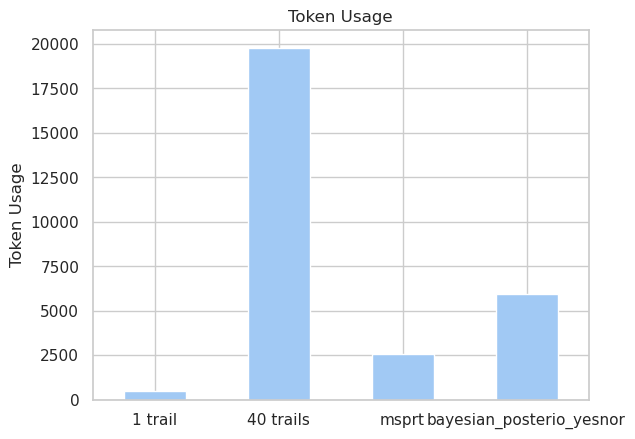

In [26]:
ax = (pd.Series([
    get_model_summary(get_model_problem_summary("published/gpqa_bayesian_posterior_multi_choice/*")).mean_token_usage,
    get_model_summary(get_model_problem_summary("published/gpqa_msprt_multi_choice/*")).mean_token_usage,
    get_model_summary(get_model_problem_summary("published/gpqa_40_trail_multi_choice/*")).mean_token_usage,
    get_model_summary(get_model_problem_summary("published/gpqa_1_trail_multi_choice/*")).mean_token_usage,
])[::-1]).to_frame().assign(label=["1 trail", "40 trails","msprt","bayesian_posterio_yesnor"]).set_index('label').plot.bar(ylabel="Token Usage", xlabel="", rot=0, legend=False)

plt.title("Token Usage")

Text(0.5, 1.0, 'Accuracy')

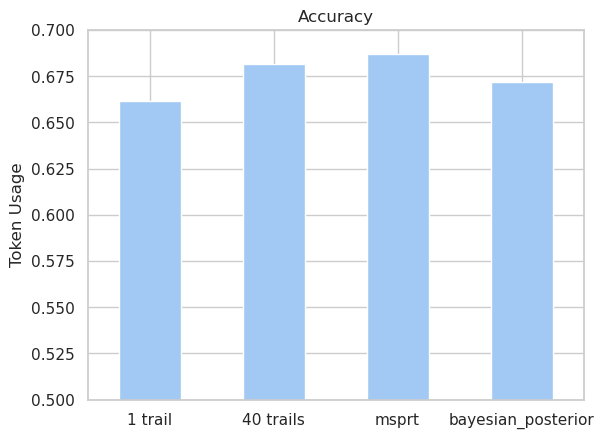

In [27]:
ax = (pd.Series([
    get_model_summary(get_model_problem_summary("published/gpqa_bayesian_posterior_multi_choice/*")).accuracy,
    get_model_summary(get_model_problem_summary("published/gpqa_msprt_multi_choice/*")).accuracy,
    get_model_summary(get_model_problem_summary("published/gpqa_40_trail_multi_choice/*")).accuracy,
    get_model_summary(get_model_problem_summary("published/gpqa_1_trail_multi_choice/*")).accuracy,
])[::-1]).to_frame().assign(label=["1 trail","40 trails", "msprt","bayesian_posterior"]).set_index('label').plot.bar(ylabel="Token Usage", xlabel="", rot=0, legend=False)


plt.ylim(0.5, 0.7)
plt.title("Accuracy")